In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
def edges(graph):
    """Creates a matrix of bools that are interpreted as the existence/non-existence (True/False)
    of edges between vertices (i,j).

    Args:
        - graph (list((float, float))): A list of x,y coordinates. e.g. graph = [(1.0, 1.1), (4.5, 3.1)]

    Returns:
        - num_edges (int): The total number of edges in the graph
        - E (np.ndarray): A Matrix of edges
    """

    # DO NOT MODIFY anything in this code block
    num_vertices = len(graph)
    E = np.zeros((num_vertices, num_vertices), dtype=bool)
    for vertex_i in range(num_vertices - 1):
        xi, yi = graph[vertex_i]  # coordinates

        for vertex_j in range(vertex_i + 1, num_vertices):
            xj, yj = graph[vertex_j]  # coordinates
            dij = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
            E[vertex_i, vertex_j] = 1 if dij <= 1.0 else 0

    return E, np.sum(E, axis=(0, 1))

In [3]:
def hamiltonian_coeffs_and_obs(graph):
    """Creates an ordered list of coefficients and observables used to construct
    the UDMIS Hamiltonian.

    Args:
        - graph (list((float, float))): A list of x,y coordinates. e.g. graph = [(1.0, 1.1), (4.5, 3.1)]

    Returns:
        - coeffs (list): List of coefficients for elementary parts of the UDMIS Hamiltonian
        - obs (list(qml.ops)): List of qml.ops
    """

    num_vertices = len(graph)
    E, num_edges = edges(graph)
    u = 1.35
    obs = []
    coeffs = []

    # QHACK #
    # First part of the hamiltonian: - sum(n_i) = -sum(1/2 * (Z_i + I_i))
    for i in range(0, num_vertices):
        coeffs.append(-1/2)
        obs.append(qml.PauliZ(i))
        coeffs.append(-1 / 2)
        obs.append(qml.Identity(i))
    # Second part of the Hamiltonian + u * sum( n_i * n_j) = + sum(u * 1/2 * (Z_i + I_i) * 1/2 * (Z_j + I_j))
    for i in range(0, len(E)):
        for j in range(0, len(E[0])):
            if E[i, j]:
                coeffs.append(u/4)
                obs.append(qml.PauliZ(i) @ qml.PauliZ(j))
                coeffs.append(u/4)
                obs.append(qml.Identity(i) @ qml.PauliZ(j))
                coeffs.append(u / 4)
                obs.append(qml.PauliZ(i) @ qml.Identity(j))
                coeffs.append(u / 4)
                obs.append(qml.Identity(i) @ qml.Identity(j))
    # QHACK #
    return coeffs, obs

In [4]:
def variational_circuit(params, num_vertices):
    """A variational circuit.

    Args:
        - params (np.ndarray): your variational parameters
        - num_vertices (int): The number of vertices in the graph. Also used for number of wires.
    """
    # QHACK #
    # Since each node can be occupied or not occupied we don't need to worry about phases and we can build VQE out of roations aroun the X axis
    for i in range(num_vertices):
        qml.RX(params[i], wires=i)
    # QHACK #

In [5]:
def train_circuit(num_vertices, H):
    """Trains a quantum circuit to learn the ground state of the UDMIS Hamiltonian.

    Args:
        - num_vertices (int): The number of vertices/wires in the graph
        - H (qml.Hamiltonian): The result of qml.Hamiltonian(coeffs, obs)

    Returns:
        - E / num_vertices (float): The ground state energy density.
    """

    dev = qml.device("default.qubit", wires=num_vertices)

    @qml.qnode(dev)
    def cost(params):
        """The energy expectation value of a Hamiltonian"""
        variational_circuit(params, num_vertices)
        return qml.expval(H)

    # QHACK #
    epochs = 500

    # Define training parameters
    num_layers = 3
    opt = qml.optimize.QNGOptimizer(stepsize=0.1)
    params = np.random.uniform(low=0, high=2 * np.pi, size=(num_vertices))

    # Optimize angles
    E_hist = []
    for i in range(epochs):
        params, E = opt.step_and_cost(cost, params)
        E_hist.append(E)
        if i % 20 == 0:
            print(f"Epoch {i} --> E: {E_hist[-1]}")
        if i > 20 and abs(E_hist[-1] - E_hist[-10]) < 1e-6:
            break
    # QHACK # 
    return E / float(num_vertices)

In [6]:
# Use this to visualize the graph
import networkx as nx
import matplotlib.pyplot as plt
def get_graph(graph):
    E, num_edges = edges(graph)
    G = nx.from_numpy_matrix(E)
    nx.draw(G, labels={node: str(node) for node in range(0, len(E))}, with_labels=True)
    plt.show()

def view_graph(graph):
    graph_dict = {i: np.array([graph[i][0], graph[i][1]]) for i in range(len(graph))}
    edges = []
    for i in range(len(graph)):
        for j in range(i + 1, len(graph)):
            coords_i = graph_dict[i]
            coords_j = graph_dict[j]
            d = sum((coords_i - coords_j)**2)
            if d <= 1.0:
                edges.append([coords_i, coords_j])
    fig, ax = plt.subplots()
    for i in graph_dict.keys():
        ax.scatter(graph_dict[i][0], graph_dict[i][1], s=100, c='b')
    for edge in edges:
        ys = [edge[i][1] for i in range(2)]
        xs = [edge[i][0] for i in range(2)]
        ax.plot(xs, ys, c='r')
    ax.set_title(f"{len(edges)} edges found")
    plt.show()

Epoch 0 --> E: -2.8571752911703463
Epoch 20 --> E: -5.986795969608368
Epoch 40 --> E: -5.999998222434092
Energy density: -1.000000


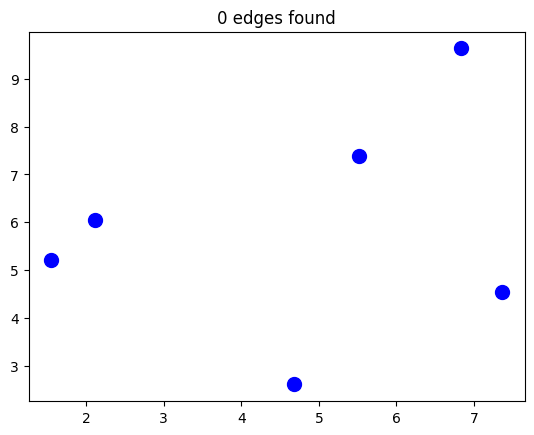

In [7]:
inputs = [4.676495520782796,2.1112909562162763,1.5485936307414583,7.361431893916296,6.832710422152228,5.513534564521993,2.611816925831103,6.054858463854695,5.222428162220638,4.552144597036618,9.630745026546073,7.387891596606659]
inputs = np.array(inputs)
num_vertices = int(len(inputs) / 2)
x = inputs[:num_vertices]
y = inputs[num_vertices:]
graph = []
for n in range(num_vertices):
    graph.append((x[n].item(), y[n].item()))

coeffs, obs = hamiltonian_coeffs_and_obs(graph)
H = qml.Hamiltonian(coeffs, obs)

energy_density = train_circuit(num_vertices, H)
print(f"Energy density: {energy_density:.6f}")

view_graph(graph)

# Since there are no edges, all vertices can be occupied E = -6 / 6 = 1

Epoch 0 --> E: -1.706322980435637
Epoch 20 --> E: -3.990761179239577
Epoch 40 --> E: -3.999640142453041
Epoch 60 --> E: -3.999980284728015
Epoch 80 --> E: -3.9999989182972366
Energy density:  -0.666667


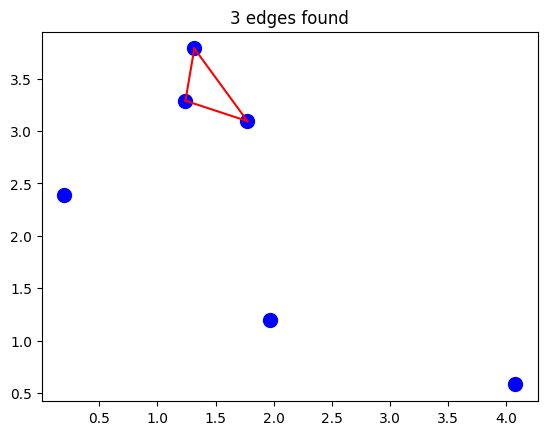

In [8]:
inputs = [1.971141343837512,1.3175151958757692,1.7743411711379486,0.19884568690295978,1.2411294078770752,4.077451769506551,1.1991102459020841,3.7875893202521675,3.0946479758878165,2.389909455806816,3.2889545392433455,0.5826862970005925]
inputs = np.array(inputs)
num_vertices = int(len(inputs) / 2)
x = inputs[:num_vertices]
y = inputs[num_vertices:]
graph = []
for n in range(num_vertices):
    graph.append((x[n].item(), y[n].item()))

coeffs, obs = hamiltonian_coeffs_and_obs(graph)
H = qml.Hamiltonian(coeffs, obs)

energy_density = train_circuit(num_vertices, H)
print(f"Energy density:  {energy_density:.6f}")

view_graph(graph)

# Since there are 3 edges forming a triangle, only 4 vertices can be occupied -> E = -4/6 = -0.66667

Epoch 0 --> E: -2.587553081370767
Epoch 20 --> E: -4.591818848732808
Epoch 40 --> E: -4.999347005226264
Epoch 60 --> E: -4.99996958352343
Epoch 80 --> E: -4.999998331691884
Energy density:  -0.833333


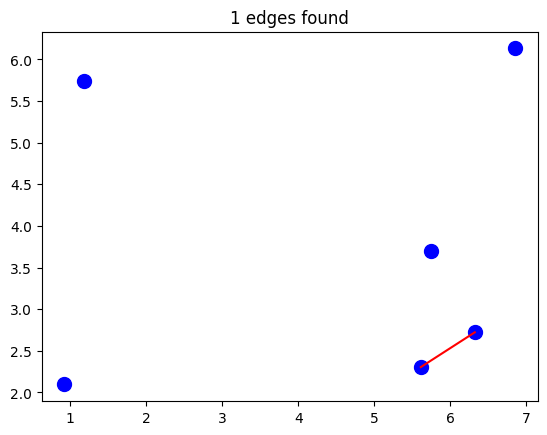

In [12]:
V = np.random.randint(6, 10)
dist = 10
inputs = np.random.random(V*2)*dist
num_vertices = int(len(inputs) / 2)
x = inputs[:num_vertices]
y = inputs[num_vertices:]
graph = []
for n in range(num_vertices):
    graph.append((x[n].item(), y[n].item()))

coeffs, obs = hamiltonian_coeffs_and_obs(graph)
H = qml.Hamiltonian(coeffs, obs)

energy_density = train_circuit(num_vertices, H)
print(f"Energy density:  {energy_density:.6f}")

view_graph(graph)